In [8]:
# Import Needed Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Enable tqdm for pandas apply if needed later
tqdm.pandas()


In [9]:
# drop index columns
US_index_cols = ['Report ID', 'Report Version']
UK_index_cols = ['Report ID', 'Report Version']

In [10]:
# Read UK scaled data
UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK_encoded_data.csv')
# Read US scaled data
US_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_encoded_data.csv')
US_data = US_data.drop(columns=US_index_cols)
UK_data = UK_data.drop(columns=UK_index_cols)

# Print shape of each DataFrame
print("UK shape:", UK_data.shape)
print("US shape:", US_data.shape)

UK shape: (229782, 21)
US shape: (4032, 21)


In [22]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Suppose the column you want to stratify on is named 'target_column'
target_col = 'Highest Injury Severity Alleged'  # replace this with your actual column name

# Stratified sampling: 20% sample size
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, sample_index in split.split(UK_data, UK_data[target_col]):
    UK_data = UK_data.iloc[sample_index]

print(UK_data[target_col].value_counts(normalize=True))  # check proportions


Highest Injury Severity Alleged
1.0    0.774478
2.0    0.210074
0.0    0.015448
Name: proportion, dtype: float64


In [23]:
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

def scale_and_preview(df_US, df_UK, scaler_type='standard'):
    """
    Scale two dataframes (e.g., US and UK) using StandardScaler or MinMaxScaler,
    and print their shapes and head previews.
    """
    # Choose the scaler
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
    else:
        raise ValueError("scaler_type must be 'standard' or 'minmax'")
    
    # Scale both dataframes
    US_scaled = scaler.fit_transform(df_US)
    UK_scaled = scaler.transform(df_UK)  # assume same features

    # Convert back to DataFrames with original column names
    US_scaled_df = pd.DataFrame(US_scaled, columns=df_US.columns)
    UK_scaled_df = pd.DataFrame(UK_scaled, columns=df_UK.columns)

    # Preview
    print("US Data Shape:", US_scaled_df.shape)
    print("UK Data Shape:", UK_scaled_df.shape)

    print("\nUK Preview:")
    print(tabulate(UK_scaled_df.head(), headers='keys', tablefmt='pretty'))

    print("\nUS Preview:")
    print(tabulate(US_scaled_df.head(), headers='keys', tablefmt='pretty'))

    return US_scaled_df, UK_scaled_df
US_df_scaled, UK_df_scaled = scale_and_preview(US_data, UK_data, scaler_type='standard')

US Data Shape: (4032, 21)
UK Data Shape: (9192, 21)

UK Preview:
+---+---------------------+--------------------+--------------------+---------------------+----------------------------+-----------------------+--------------------+---------------------+--------------------+----------------------+--------------------------+--------------------+---------------------+---------------------------------+-----------------------+---------------------+---------------------+---------+---------------------+---------------------+---------------------+
|   |        Make         |       Model        |     Model Year     |    ADS Equipped?    | Automation System Engaged? | Incident Time (24:00) |        City        |        State        |    Roadway Type    |   Roadway Surface    | Posted Speed Limit (MPH) |      Lighting      |     Crash With      | Highest Injury Severity Alleged | SV Pre-Crash Movement |       Weather       |   SV Contact Area   | Country |    Incident_Year    |   Incident_Month   

**Sampling Methods for Clustering**

US


KMeans Clustering Progress: 100%|██████████| 9/9 [00:01<00:00,  4.90it/s]


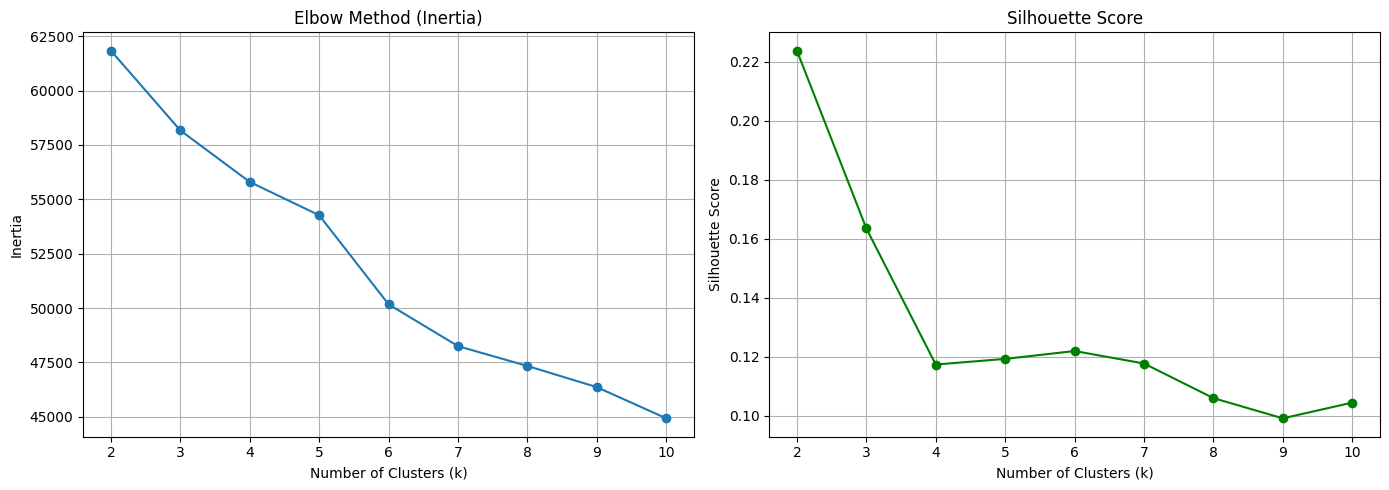

UK


KMeans Clustering Progress: 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


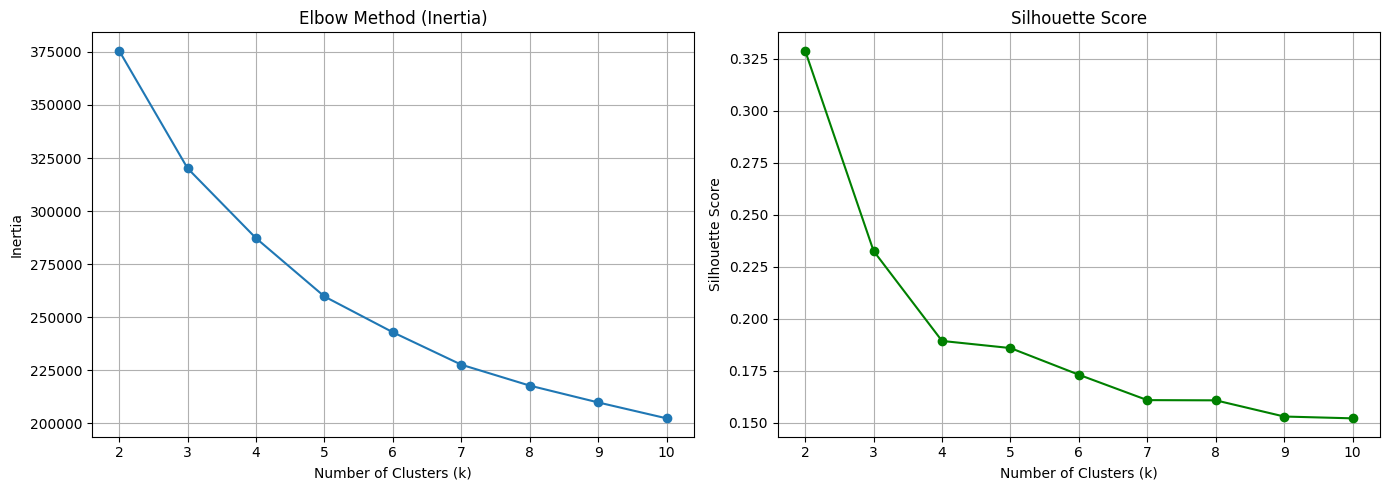

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm


def plot_kmeans_elbow_silhouette(data, max_k=10):
    inertias = []
    silhouettes = []
    Ks = range(2, max_k + 1)

    for k in tqdm(Ks, desc="KMeans Clustering Progress"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=1)
        labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(data, labels))

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(Ks, inertias, marker='o')
    ax[0].set_title('Elbow Method (Inertia)')
    ax[0].set_xlabel('Number of Clusters (k)')
    ax[0].set_ylabel('Inertia')
    ax[0].grid(True)

    ax[1].plot(Ks, silhouettes, marker='o', color='green')
    ax[1].set_title('Silhouette Score')
    ax[1].set_xlabel('Number of Clusters (k)')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

print("US")
plot_kmeans_elbow_silhouette(US_df_scaled, max_k=10)

print("UK")
plot_kmeans_elbow_silhouette(UK_df_scaled, max_k=10)  # No sampling needed now




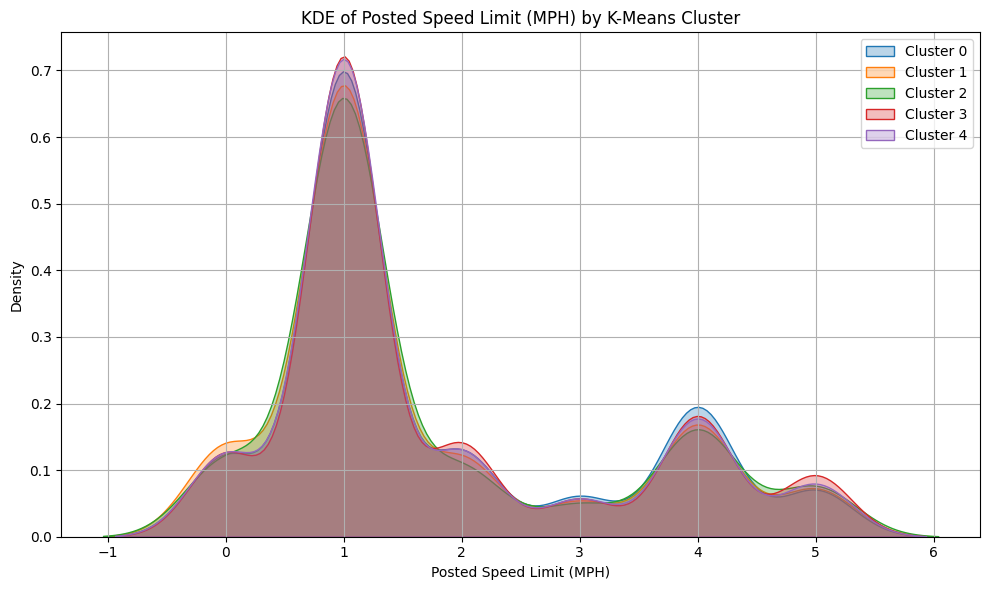

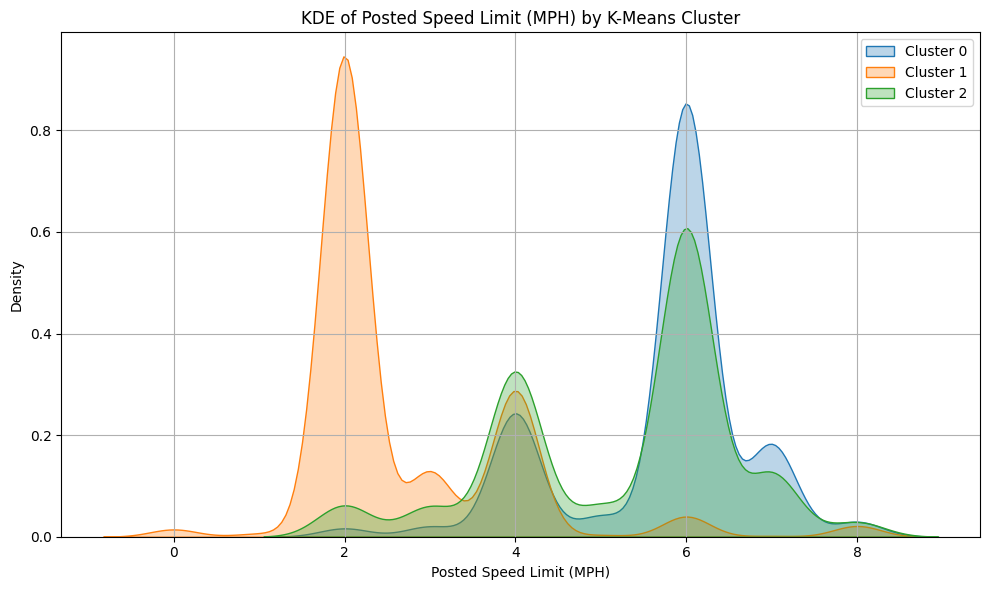

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def kmeans_cluster_speed_kde(scaled_df, original_df, n_clusters=3, speed_col='Posted Speed Limit (MPH)'):
    """
    Performs KMeans clustering on scaled data and plots KDEs of the posted speed limit per cluster.

    Parameters:
    - scaled_df: DataFrame that has been scaled (e.g., with StandardScaler).
    - original_df: Original, unscaled DataFrame with speed_col column.
    - n_clusters: Number of KMeans clusters.
    - speed_col: Name of the speed column in original_df.

    Returns:
    - original_df with a new 'cluster' column.
    """

    # Step 1: Apply K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df)

    # Step 2: Add cluster labels to original DataFrame
    original_df = original_df.copy()
    original_df['cluster'] = cluster_labels

    # Step 3: KDE Plot of Posted Speed Limit by Cluster
    plt.figure(figsize=(10, 6))
    for cluster_id in range(n_clusters):
        subset = original_df[original_df['cluster'] == cluster_id]
        sns.kdeplot(subset[speed_col], label=f'Cluster {cluster_id}', fill=True, alpha=0.3)

    plt.title(f'KDE of {speed_col} by K-Means Cluster')
    plt.xlabel(speed_col)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return original_df

# Example usage:
UK_df_with_clusters = kmeans_cluster_speed_kde(UK_df_scaled, UK_data, n_clusters=5, speed_col='Posted Speed Limit (MPH)')
US_df_with_clusters = kmeans_cluster_speed_kde(US_df_scaled, US_data, n_clusters=3, speed_col='Posted Speed Limit (MPH)')

**PCA plot to see if any clusters**

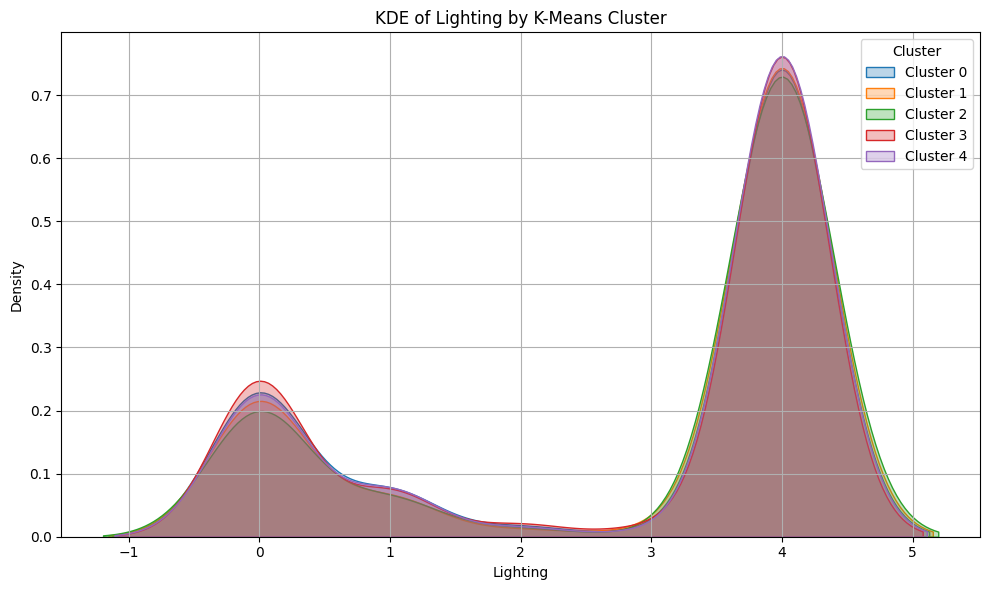

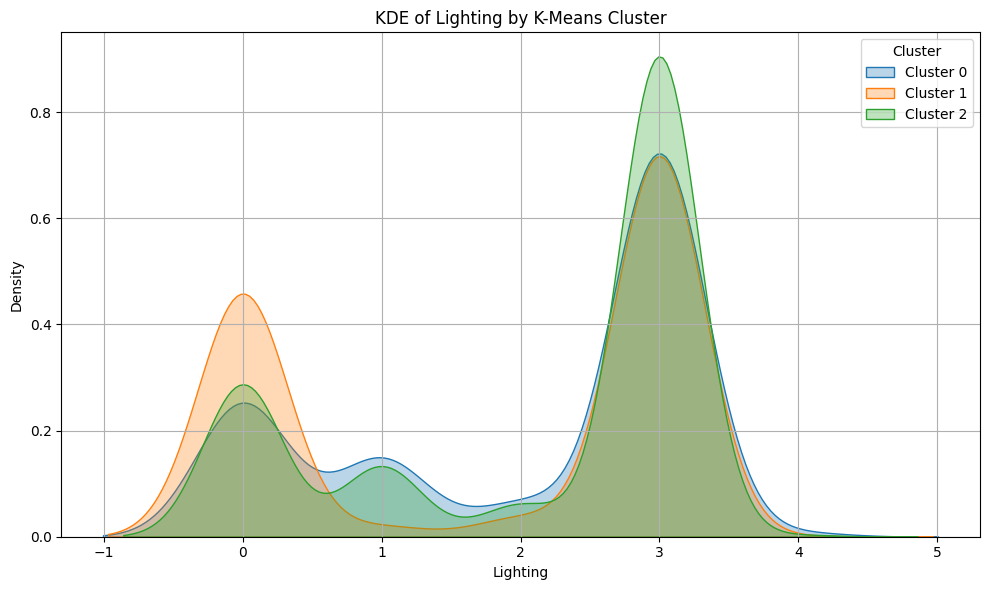

In [27]:
UK_age_clusters = kmeans_cluster_plot(UK_df_scaled, UK_data, n_clusters=5, plot_col='Lighting')
US_age_clusters = kmeans_cluster_plot(US_df_scaled, US_data, n_clusters=3, plot_col='Lighting')

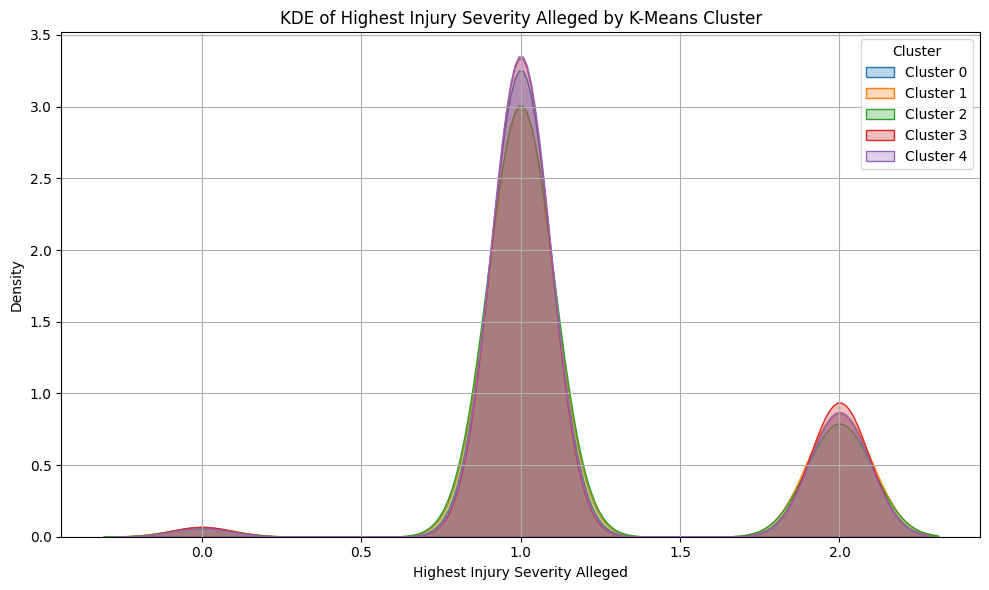

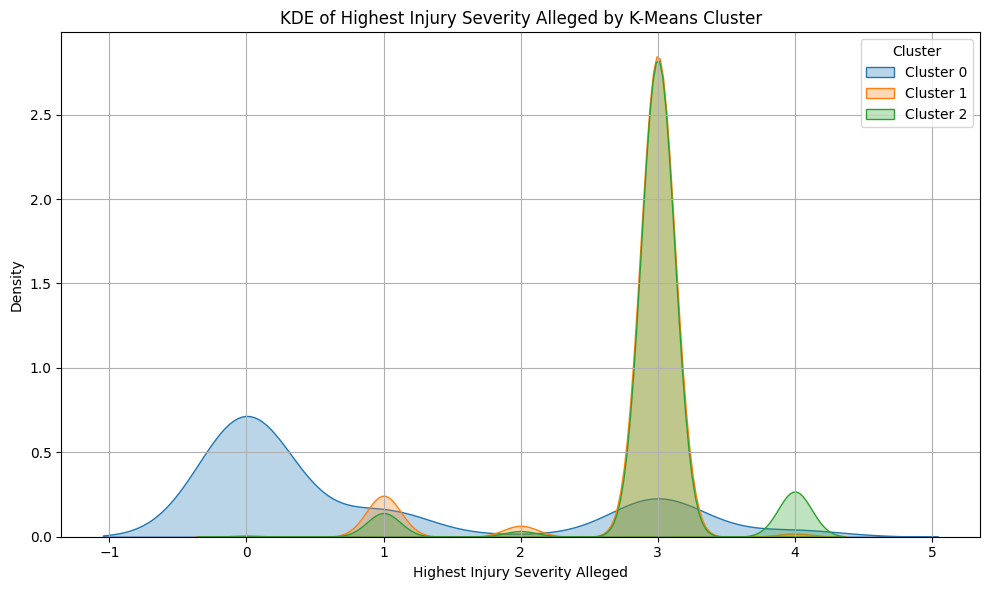

In [28]:
UK_age_clusters = kmeans_cluster_plot(UK_df_scaled, UK_data, n_clusters=5, plot_col='Highest Injury Severity Alleged')
US_age_clusters = kmeans_cluster_plot(US_df_scaled, US_data, n_clusters=3, plot_col='Highest Injury Severity Alleged')

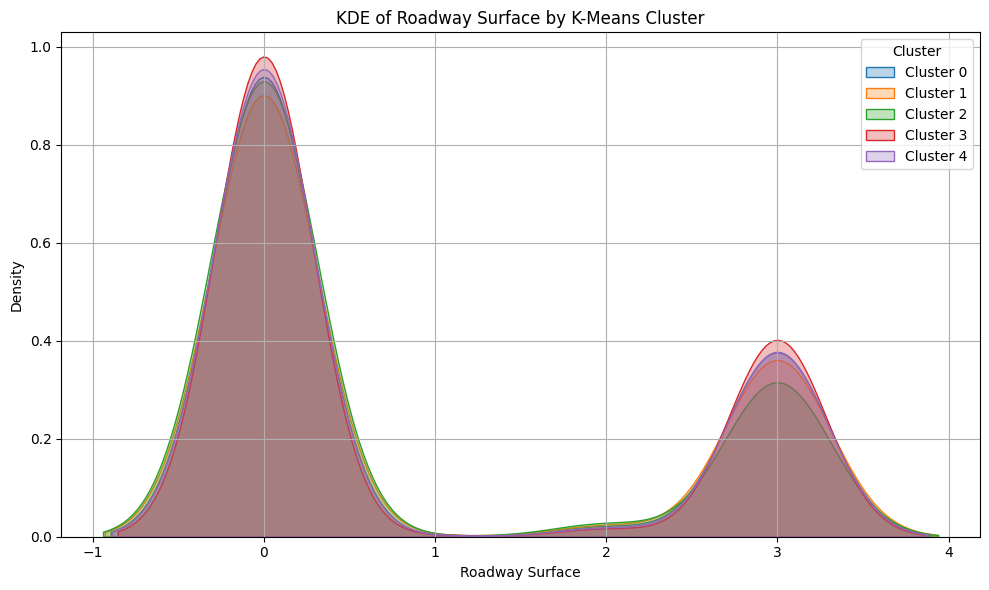

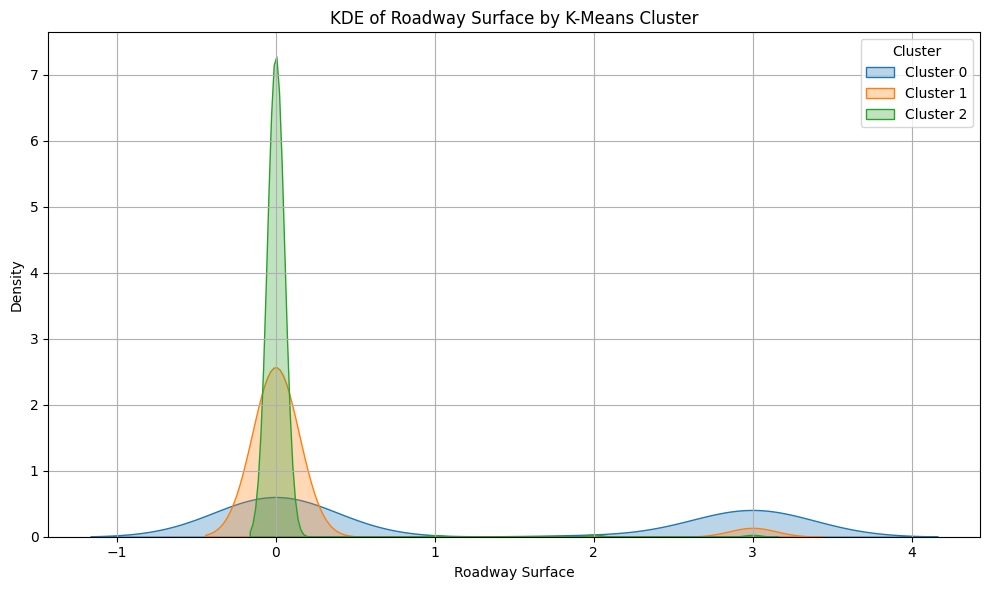

In [29]:
UK_age_clusters = kmeans_cluster_plot(UK_df_scaled, UK_data, n_clusters=5, plot_col='Roadway Surface')
US_age_clusters = kmeans_cluster_plot(US_df_scaled, US_data, n_clusters=3, plot_col='Roadway Surface')

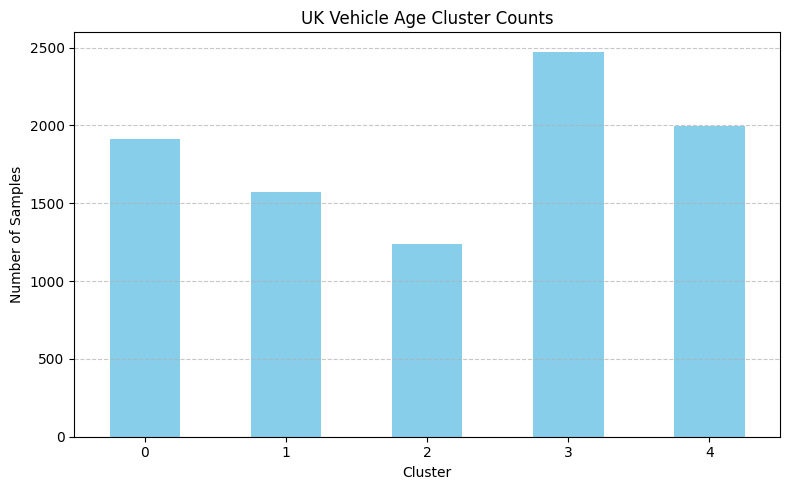

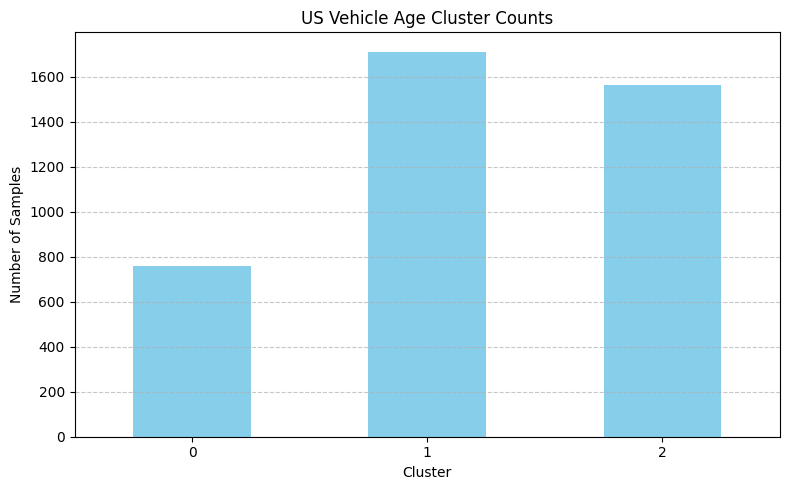

In [30]:
# number of clusters
import matplotlib.pyplot as plt

def plot_cluster_counts(clustered_df, cluster_col='cluster', title='Number of Samples per Cluster'):
    counts = clustered_df[cluster_col].value_counts().sort_index()
    
    plt.figure(figsize=(8, 5))
    counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
# Assuming UK_age_clusters and US_age_clusters are the outputs from your clustering function
plot_cluster_counts(UK_age_clusters, cluster_col='cluster', title='UK Vehicle Age Cluster Counts')
plot_cluster_counts(US_age_clusters, cluster_col='cluster', title='US Vehicle Age Cluster Counts')

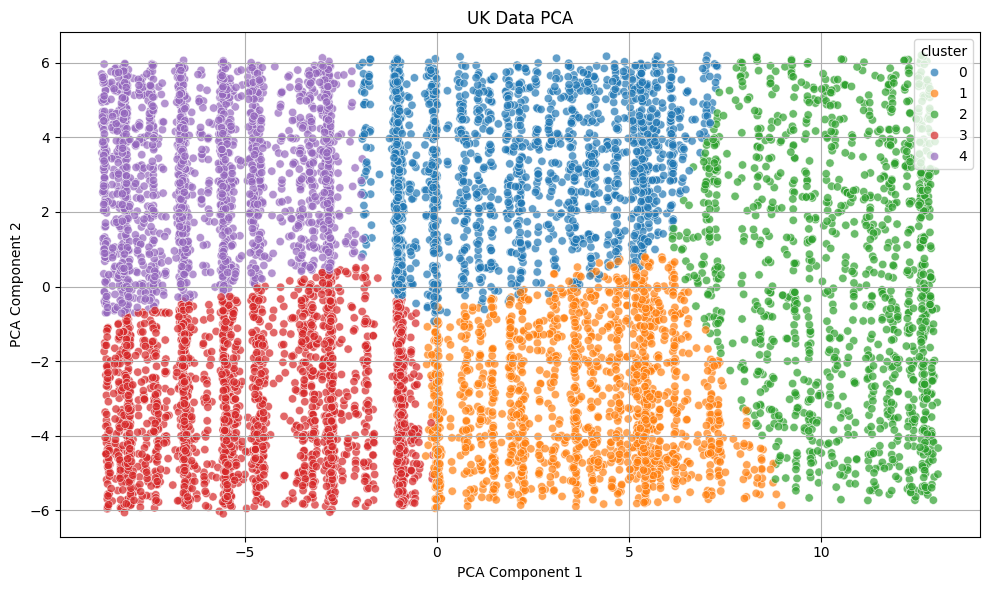

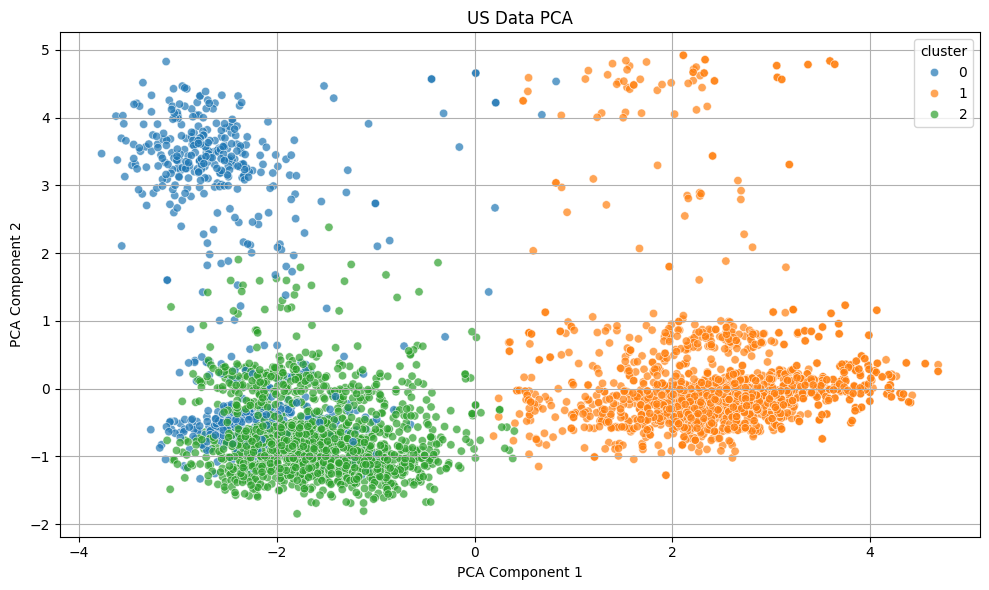

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_pca_2d(scaled_df, original_df, title='PCA of Data'):
    """
    Plots the first two PCA components of the scaled data, colored by cluster if present.
    Also prints the mode of each feature grouped by cluster.
    """
    # Apply PCA
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(scaled_df)

    # Copy and append PCA results
    pca_df = original_df.copy()
    pca_df['PCA1'] = pca_components[:, 0]
    pca_df['PCA2'] = pca_components[:, 1]

    # Plot
    plt.figure(figsize=(10, 6))
    if 'cluster' in original_df.columns:
        sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='tab10', alpha=0.7)
    else:
        sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', alpha=0.6)

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Example usage:
plot_pca_2d(UK_df_scaled, UK_df_with_clusters, title='UK Data PCA')
plot_pca_2d(US_df_scaled, US_df_with_clusters, title='US Data PCA')

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cluster full UK dataset first
UK_df_scaled['cluster'] = KMeans(n_clusters=5, random_state=42).fit_predict(UK_df_scaled)

# 2. Stratified sample
def stratified_sample(df, stratify_col, n_samples, random_state=42):
    proportions = df[stratify_col].value_counts(normalize=True)
    samples_per_group = (proportions * n_samples).round().astype(int)
    sampled_df = (
        df.groupby(stratify_col, group_keys=False)
          .apply(lambda x: x.sample(samples_per_group[x.name], random_state=random_state))
          .reset_index(drop=True)
    )
    return sampled_df
# 3. Run t-SNE on the stratified sample
tsne = TSNE(n_components=2, random_state=42, perplexity=15, max_iter=250, verbose=1)
tsne_results = tsne.fit_transform(UK_sampled_stratified.drop(columns=['cluster']))

UK_sampled_stratified['tsne_1'] = tsne_results[:, 0]
UK_sampled_stratified['tsne_2'] = tsne_results[:, 1]

# 4. Plot
def plot_tsne_2d(df, title='t-SNE of Data'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='tsne_1', y='tsne_2', hue='cluster', palette='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_tsne_2d(UK_sampled_stratified, title='UK Data t-SNE (Stratified Sample)')



ValueError: Cannot take a larger sample than population when 'replace=False'

Running t-SNE on UK data...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4032 samples in 0.000s...
[t-SNE] Computed neighbors for 4032 samples in 0.221s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4032
[t-SNE] Computed conditional probabilities for sample 2000 / 4032
[t-SNE] Computed conditional probabilities for sample 3000 / 4032
[t-SNE] Computed conditional probabilities for sample 4000 / 4032
[t-SNE] Computed conditional probabilities for sample 4032 / 4032
[t-SNE] Mean sigma: 1.337661
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.959076
[t-SNE] KL divergence after 1000 iterations: 1.299855


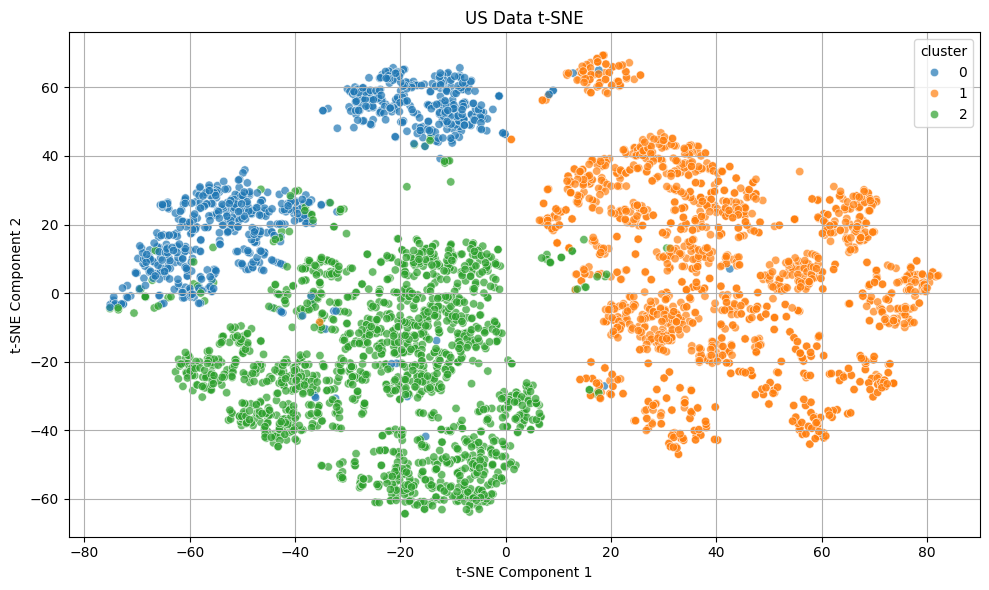

In [ ]:
import seaborn as sns

US_sampled = US_df_scaled

# STEP 3: Apply KMeans clustering on the sample
US_clusters = KMeans(n_clusters=3, random_state=42).fit_predict(US_sampled)
US_sampled['cluster'] = US_clusters

# STEP 4: Apply t-SNE on the sample (excluding cluster column)
print("Running t-SNE on UK data...")
tsne_uk = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1)
tsne_results_uk = tsne_uk.fit_transform(US_sampled.drop(columns=['cluster']))

# STEP 5: Add t-SNE components to sampled data
US_sampled['tsne_1'] = tsne_results_uk[:, 0]
US_sampled['tsne_2'] = tsne_results_uk[:, 1]

# STEP 6: Plotting function
def plot_tsne_2d(df, title='t-SNE of Data'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='tsne_1', y='tsne_2', hue='cluster', palette='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_tsne_2d(US_sampled, title='US Data t-SNE')
plot_tsne_2d(UK_sampled, title='US Data t-SNE')

In [ ]:
US_df_scaled.head()
print("Columns:", list(US_df_scaled.columns))



Columns: ['Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?', 'Incident Time (24:00)', 'City', 'State', 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting', 'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement', 'Weather', 'SV Contact Area', 'Country', 'Incident_Year', 'Incident_Month', 'Incident_DayOfWeek', 'cluster', 'tsne_1', 'tsne_2']


In [ ]:
# Assuming US_sampled and US_data have same index and rows correspond

categorical_cols = ['Make', 'Model', 'Model Year', 'ADS Equipped?', 
'Automation System Engaged?', 'Incident Time (24:00)', 'City', 'State',
 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting',
  'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement',
   'Weather', 'SV Contact Area', 'Country']

# Select original categorical data columns
original_cats = US_data[categorical_cols]

# Add cluster labels to US_data so you can groupby cluster and get modes on original data
US_data_with_clusters = original_cats.copy()
US_data_with_clusters['cluster'] = US_sampled['cluster']

# Now get modes on original data grouped by cluster
cluster_modes_original = (
    US_data_with_clusters
    .groupby('cluster')
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
).reset_index()

from tabulate import tabulate
print(tabulate(cluster_modes_original, headers='keys', tablefmt='grid'))




+----+-----------+--------+---------+--------------+-----------------+------------------------------+-------------------------+---------------+---------+-------------------+-------------------+----------------------------+------------+--------------------+-----------------------------------+-------------------------+--------------+-------------------+-----------+
|    |   cluster | Make   | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Time (24:00)   | City          | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting   | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather      | SV Contact Area   | Country   |
+====+===========+========+=========+==============+=================+==============================+=========================+===============+=========+===================+===================+============================+============+====================+============

In [ ]:
# Assuming US_sampled and US_data have same index and rows correspond

categorical_cols = ['Make', 'Model', 'Model Year', 'Incident Time (24:00)', 'City', 'State',
 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting',
  'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement',
   'Weather', 'SV Contact Area']

# Select original categorical data columns
original_cats = UK_data[categorical_cols]

# Add cluster labels to US_data so you can groupby cluster and get modes on original data
UK_data_with_clusters = original_cats.copy()
UK_data_with_clusters['cluster'] = UK_sampled_stratified['cluster']

# Now get modes on original data grouped by cluster
cluster_modes_original = (
    UK_data_with_clusters
    .groupby('cluster')
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
).reset_index()

from tabulate import tabulate
print(tabulate(cluster_modes_original, headers='keys', tablefmt='grid'))


+----+-----------+----------+---------+--------------+-------------------------+--------------------+---------+--------------------+-------------------+----------------------------+------------+--------------+-----------------------------------+-------------------------+-----------+-------------------+
|    |   cluster | Make     | Model   |   Model Year | Incident Time (24:00)   | City               | State   | Roadway Type       | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting   | Crash With   | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area   |
+====+===========+==========+=========+==============+=========================+====================+=========+====================+===================+============================+============+==============+===================================+=========================+===========+===================+
|  0 |         0 | VAUXHALL | FIESTA  |         2018 | 17:00:00                | Preston

Running 3D t-SNE on US data...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4159 samples in 0.001s...
[t-SNE] Computed neighbors for 4159 samples in 0.279s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4159
[t-SNE] Computed conditional probabilities for sample 2000 / 4159
[t-SNE] Computed conditional probabilities for sample 3000 / 4159
[t-SNE] Computed conditional probabilities for sample 4000 / 4159
[t-SNE] Computed conditional probabilities for sample 4159 / 4159
[t-SNE] Mean sigma: 3.180648
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.748646
[t-SNE] KL divergence after 1000 iterations: 0.285754


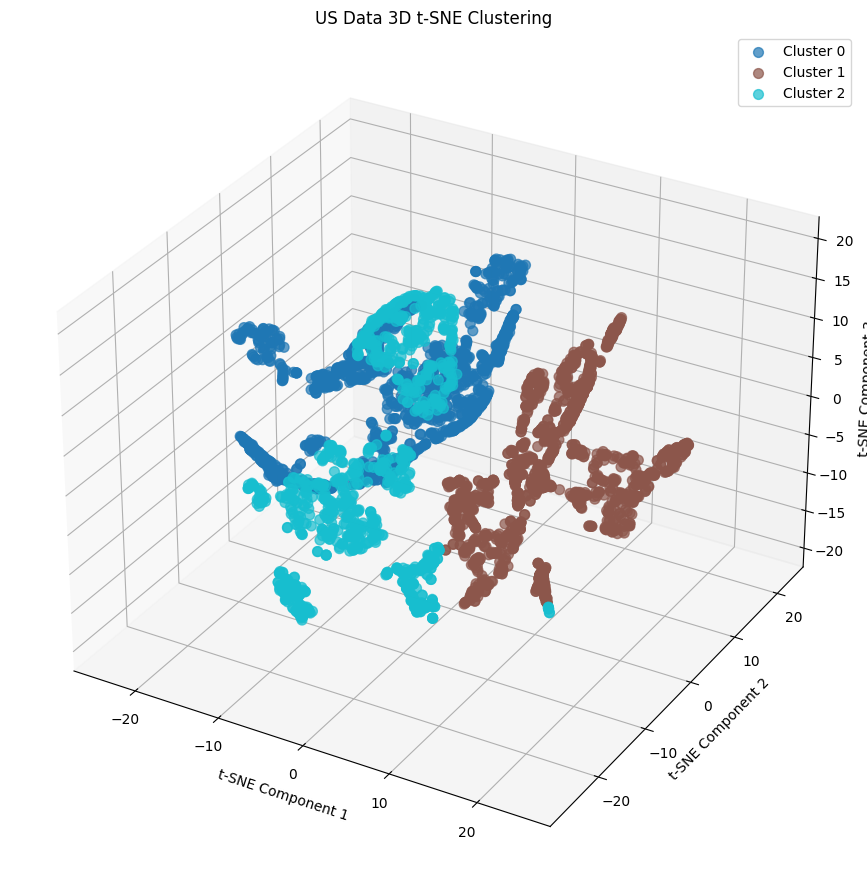


Cluster Statistics:
cluster
0    1504
1    1590
2    1065
Name: count, dtype: int64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np

# Your existing data preparation
US_sampled = US_df_scaled

# STEP 3: Apply KMeans clustering on the sample
US_clusters = KMeans(n_clusters=3, random_state=42).fit_predict(US_sampled)
US_sampled['cluster'] = US_clusters

# STEP 4: Apply t-SNE with 3 components for 3D visualization
print("Running 3D t-SNE on US data...")
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, max_iter=1000, verbose=1)
tsne_results_3d = tsne_3d.fit_transform(US_sampled.drop(columns=['cluster']))

# STEP 5: Add t-SNE components to sampled data
US_sampled['tsne_1'] = tsne_results_3d[:, 0]
US_sampled['tsne_2'] = tsne_results_3d[:, 1]
US_sampled['tsne_3'] = tsne_results_3d[:, 2]

# STEP 6: 3D Plotting function
def plot_tsne_3d(df, title='3D t-SNE of Data'):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get unique clusters and colors
    unique_clusters = df['cluster'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    
    # Plot each cluster with different colors
    for i, cluster in enumerate(unique_clusters):
        cluster_data = df[df['cluster'] == cluster]
        ax.scatter(cluster_data['tsne_1'], 
                  cluster_data['tsne_2'], 
                  cluster_data['tsne_3'],
                  c=[colors[i]], 
                  label=f'Cluster {cluster}',
                  alpha=0.7,
                  s=50)
    
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    ax.set_title(title)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Create the 3D plot
plot_tsne_3d(US_sampled, title='US Data 3D t-SNE Clustering')

# Optional: Interactive 3D plot using plotly (if you have it installed)
def plot_tsne_3d_interactive(df, title='Interactive 3D t-SNE of Data'):
    try:
        import plotly.express as px
        
        fig = px.scatter_3d(df, 
                           x='tsne_1', 
                           y='tsne_2', 
                           z='tsne_3',
                           color='cluster',
                           title=title,
                           color_discrete_sequence=px.colors.qualitative.Set1)
        
        fig.update_traces(marker=dict(size=5, opacity=0.7))
        fig.update_layout(scene=dict(
            xaxis_title='t-SNE Component 1',
            yaxis_title='t-SNE Component 2',
            zaxis_title='t-SNE Component 3'
        ))
        
        fig.show()
        
    except ImportError:
        print("Plotly not installed. Install with: pip install plotly")

# Uncomment the line below to create interactive plot
# plot_tsne_3d_interactive(US_sampled, title='US Data Interactive 3D t-SNE Clustering')

# Print cluster statistics
print("\nCluster Statistics:")
print(US_sampled['cluster'].value_counts().sort_index())

# Optional: Analyze clusters with categorical data
categorical_cols = ['Make', 'Model', 'Model Year', 'ADS Equipped?', 
                   'Automation System Engaged?', 'Incident Time (24:00)', 'City', 'State',
                   'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting',
                   'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement',
                   'Weather', 'SV Contact Area', 'Country']

def analyze_clusters_by_categories(df, categorical_cols, top_n=3):
    """Analyze cluster characteristics based on categorical variables"""
    
    # Only use categorical columns that exist in the dataframe
    available_cats = [col for col in categorical_cols if col in df.columns]
    
    for cluster_id in sorted(df['cluster'].unique()):
        print(f"\n=== CLUSTER {cluster_id} ===")
        cluster_data = df[df['cluster'] == cluster_id]
        print(f"Size: {len(cluster_data)} samples")
        
        for col in available_cats[:5]:  # Show top 5 categorical columns
            if col in cluster_data.columns:
                top_values = cluster_data[col].value_counts().head(top_n)
                print(f"\nTop {col}:")
                for value, count in top_values.items():
                    percentage = (count / len(cluster_data)) * 100
                    print(f"  {value}: {count} ({percentage:.1f}%)")

# Uncomment to analyze clusters
# analyze_clusters_by_categories(US_sampled, categorical_cols)

COMPREHENSIVE CLUSTER ANALYSIS
=== PCA ANALYSIS ===
Explained variance ratio: [0.39803809 0.34440198 0.21318671]
Cumulative explained variance: [0.39803809 0.74244007 0.95562678]

=== TOP FEATURE CONTRIBUTIONS TO EACH COMPONENT ===

PC1 (explains 39.8% of variance):
  tsne_2: 0.995
  tsne_1: -0.057
  Roadway Surface: -0.048
  tsne_3: -0.037
  Lighting: 0.032
  Highest Injury Severity Alleged: 0.017
  Roadway Type: 0.017
  ADS Equipped?: 0.016
  SV Pre-Crash Movement: 0.016
  Automation System Engaged?: 0.016

PC2 (explains 34.4% of variance):
  tsne_1: 0.982
  ADS Equipped?: 0.070
  Automation System Engaged?: 0.070
  Posted Speed Limit (MPH): -0.059
  Make: -0.057
  Incident_Year: -0.055
  tsne_2: 0.053
  Model: -0.046
  Weather: -0.046
  Roadway Type: 0.042

PC3 (explains 21.3% of variance):
  tsne_3: 0.993
  Make: 0.051
  Automation System Engaged?: -0.049
  ADS Equipped?: -0.049
  tsne_2: 0.039
  Model: 0.030
  Highest Injury Severity Alleged: 0.024
  Lighting: -0.023
  Posted Spee

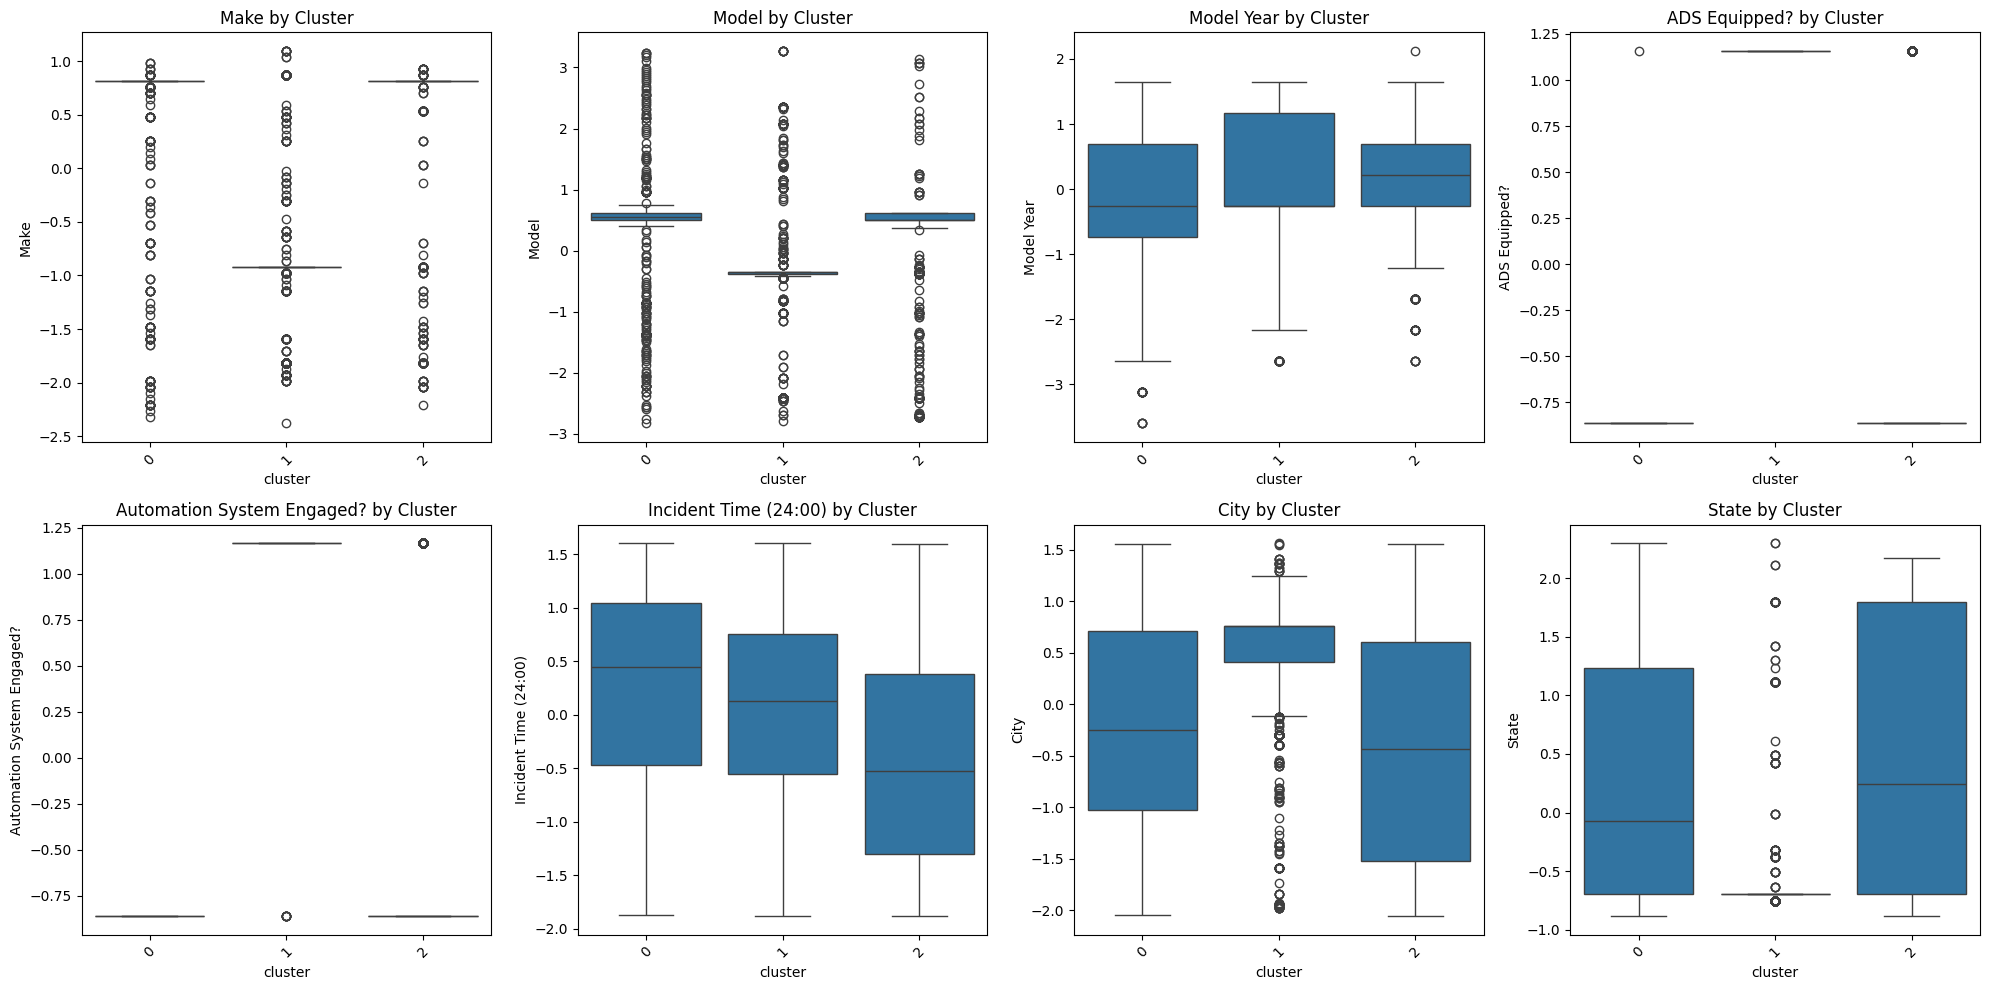

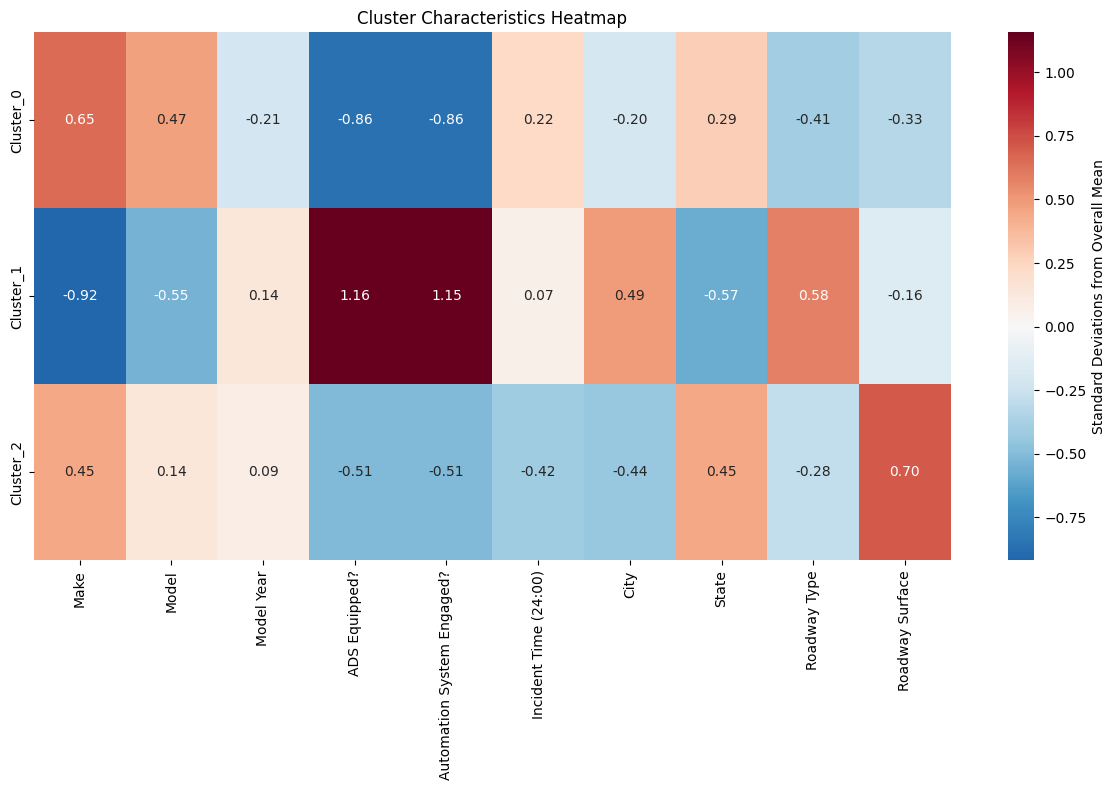

Suggested cluster names: {0: 'Cluster_0', 1: 'High_ADS Equipped?_High_Automation System Engaged?', 2: 'Cluster_2'}
Top important features:                        feature  importance
22                      tsne_2    0.155719
21                      tsne_1    0.120852
3                ADS Equipped?    0.109339
4   Automation System Engaged?    0.106322
0                         Make    0.069335
23                      tsne_3    0.060867
1                        Model    0.049676
7                        State    0.041272
9              Roadway Surface    0.040189
18               Incident_Year    0.037248


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# METHOD 1: PCA ANALYSIS (More interpretable than t-SNE)
# ============================================================================

def analyze_with_pca(df_scaled, clusters, n_components=3):
    """Use PCA instead of t-SNE for more interpretable components"""
    
    # Remove cluster column if it exists
    feature_data = df_scaled.drop(columns=['cluster'], errors='ignore')
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(feature_data)
    
    # Create DataFrame with PCA results
    pca_df = pd.DataFrame(pca_results, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['cluster'] = clusters
    
    print("=== PCA ANALYSIS ===")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")
    
    # Show feature contributions to each component
    feature_names = feature_data.columns
    components_df = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=feature_names
    )
    
    print("\n=== TOP FEATURE CONTRIBUTIONS TO EACH COMPONENT ===")
    for i in range(n_components):
        pc_name = f'PC{i+1}'
        print(f"\n{pc_name} (explains {pca.explained_variance_ratio_[i]:.1%} of variance):")
        
        # Get top positive and negative contributors
        contributions = components_df[pc_name].abs().sort_values(ascending=False)
        top_features = contributions.head(10)
        
        for feature in top_features.index:
            coeff = components_df.loc[feature, pc_name]
            print(f"  {feature}: {coeff:.3f}")
    
    return pca_df, pca, components_df

# ============================================================================
# METHOD 2: STATISTICAL CLUSTER PROFILING
# ============================================================================

def statistical_cluster_analysis(df, cluster_col='cluster'):
    """Comprehensive statistical analysis of clusters"""
    
    print("=== STATISTICAL CLUSTER ANALYSIS ===")
    
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Remove cluster column from analysis
    if cluster_col in numerical_cols:
        numerical_cols.remove(cluster_col)
    if cluster_col in categorical_cols:
        categorical_cols.remove(cluster_col)
    
    cluster_profiles = {}
    
    for cluster_id in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster_id]
        cluster_profiles[cluster_id] = {}
        
        print(f"\n=== CLUSTER {cluster_id} ({len(cluster_data)} samples) ===")
        
        # Numerical features analysis
        if numerical_cols:
            print("\nNumerical Features (mean ± std):")
            for col in numerical_cols[:10]:  # Show top 10
                cluster_mean = cluster_data[col].mean()
                cluster_std = cluster_data[col].std()
                overall_mean = df[col].mean()
                
                # Calculate how different this cluster is from overall mean
                diff_from_overall = (cluster_mean - overall_mean) / df[col].std()
                
                cluster_profiles[cluster_id][col] = {
                    'mean': cluster_mean,
                    'std': cluster_std,
                    'diff_from_overall': diff_from_overall
                }
                
                status = "HIGH" if diff_from_overall > 0.5 else "LOW" if diff_from_overall < -0.5 else "NORMAL"
                print(f"  {col}: {cluster_mean:.3f} ± {cluster_std:.3f} ({status})")
        
        # Categorical features analysis
        if categorical_cols:
            print("\nTop Categorical Features:")
            for col in categorical_cols[:5]:  # Show top 5
                if col in cluster_data.columns and not cluster_data[col].isna().all():
                    top_values = cluster_data[col].value_counts().head(3)
                    cluster_profiles[cluster_id][col] = top_values.to_dict()
                    
                    print(f"  {col}:")
                    for value, count in top_values.items():
                        percentage = (count / len(cluster_data)) * 100
                        print(f"    {value}: {percentage:.1f}%")
    
    return cluster_profiles

# ============================================================================
# METHOD 3: FEATURE IMPORTANCE FOR CLUSTER PREDICTION
# ============================================================================

def cluster_feature_importance(df, cluster_col='cluster'):
    """Use Random Forest to find which features best predict clusters"""
    
    print("\n=== FEATURE IMPORTANCE FOR CLUSTER PREDICTION ===")
    
    # Prepare data
    feature_data = df.drop(columns=[cluster_col])
    
    # Handle categorical variables (simple encoding)
    feature_data_encoded = pd.get_dummies(feature_data, drop_first=True)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(feature_data_encoded, df[cluster_col])
    
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': feature_data_encoded.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 Most Important Features for Cluster Prediction:")
    for idx, row in importance_df.head(15).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    return importance_df, rf

# ============================================================================
# METHOD 4: CLUSTER COMPARISON AND NAMING SUGGESTIONS
# ============================================================================

def suggest_cluster_names(cluster_profiles, categorical_cols):
    """Suggest meaningful names for clusters based on their characteristics"""
    
    print("\n=== CLUSTER NAMING SUGGESTIONS ===")
    
    suggestions = {}
    
    for cluster_id, profile in cluster_profiles.items():
        characteristics = []
        
        # Look for dominant categorical features
        for col in categorical_cols[:5]:
            if col in profile:
                if isinstance(profile[col], dict):
                    top_value = max(profile[col], key=profile[col].get)
                    if profile[col][top_value] > len(cluster_profiles) * 20:  # If >20% of cluster
                        characteristics.append(f"{col}_{top_value}")
        
        # Look for extreme numerical features
        for feature, stats in profile.items():
            if isinstance(stats, dict) and 'diff_from_overall' in stats:
                if abs(stats['diff_from_overall']) > 1:  # More than 1 std dev different
                    direction = "High" if stats['diff_from_overall'] > 0 else "Low"
                    characteristics.append(f"{direction}_{feature}")
        
        # Create suggestion
        if characteristics:
            suggestion = "_".join(characteristics[:3])  # Take top 3 characteristics
        else:
            suggestion = f"Cluster_{cluster_id}"
        
        suggestions[cluster_id] = suggestion
        print(f"Cluster {cluster_id}: '{suggestion}'")
    
    return suggestions

# ============================================================================
# METHOD 5: VISUALIZATION HELPERS
# ============================================================================

def plot_cluster_comparison(df, feature_cols, cluster_col='cluster', max_features=8):
    """Create comparison plots for clusters"""
    
    # Select numerical features only
    numerical_features = df[feature_cols].select_dtypes(include=[np.number]).columns[:max_features]
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(numerical_features):
        if i < len(axes):
            sns.boxplot(data=df, x=cluster_col, y=feature, ax=axes[i])
            axes[i].set_title(f'{feature} by Cluster')
            axes[i].tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for i in range(len(numerical_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_cluster_heatmap(cluster_profiles):
    """Create a heatmap showing cluster characteristics"""
    
    # Extract numerical features for heatmap
    numerical_data = {}
    features = []
    
    for cluster_id, profile in cluster_profiles.items():
        numerical_data[f'Cluster_{cluster_id}'] = {}
        for feature, stats in profile.items():
            if isinstance(stats, dict) and 'diff_from_overall' in stats:
                numerical_data[f'Cluster_{cluster_id}'][feature] = stats['diff_from_overall']
                if feature not in features:
                    features.append(feature)
    
    if numerical_data and features:
        heatmap_df = pd.DataFrame(numerical_data).T
        heatmap_df = heatmap_df[features[:15]]  # Top 15 features
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(heatmap_df, annot=True, cmap='RdBu_r', center=0, 
                   fmt='.2f', cbar_kws={'label': 'Standard Deviations from Overall Mean'})
        plt.title('Cluster Characteristics Heatmap')
        plt.tight_layout()
        plt.show()

# ============================================================================
# MAIN ANALYSIS FUNCTION
# ============================================================================

def comprehensive_cluster_analysis(df_scaled, clusters, categorical_cols):
    """Run all analysis methods"""
    
    # Add clusters to dataframe
    df_with_clusters = df_scaled.copy()
    df_with_clusters['cluster'] = clusters
    
    print("COMPREHENSIVE CLUSTER ANALYSIS")
    print("=" * 50)
    
    # Method 1: PCA Analysis
    pca_df, pca_model, components_df = analyze_with_pca(df_scaled, clusters)
    
    # Method 2: Statistical Analysis
    cluster_profiles = statistical_cluster_analysis(df_with_clusters)
    
    # Method 3: Feature Importance
    importance_df, rf_model = cluster_feature_importance(df_with_clusters)
    
    # Method 4: Naming Suggestions
    name_suggestions = suggest_cluster_names(cluster_profiles, categorical_cols)
    
    # Method 5: Visualizations
    print("\nCreating visualizations...")
    plot_cluster_comparison(df_with_clusters, df_scaled.columns)
    create_cluster_heatmap(cluster_profiles)
    
    return {
        'pca_results': pca_df,
        'pca_model': pca_model,
        'components': components_df,
        'cluster_profiles': cluster_profiles,
        'feature_importance': importance_df,
        'name_suggestions': name_suggestions,
        'rf_model': rf_model
    }

# ============================================================================
# HOW TO USE
# ============================================================================

# Example usage:
results = comprehensive_cluster_analysis(US_df_scaled, US_clusters, categorical_cols)

# To access specific results:
print("Suggested cluster names:", results['name_suggestions'])
print("Top important features:", results['feature_importance'].head(10))

Running 2D t-SNE on UK data...
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 29999 samples in 0.002s...
[t-SNE] Computed neighbors for 29999 samples in 0.775s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29999
[t-SNE] Computed conditional probabilities for sample 2000 / 29999
[t-SNE] Computed conditional probabilities for sample 3000 / 29999
[t-SNE] Computed conditional probabilities for sample 4000 / 29999
[t-SNE] Computed conditional probabilities for sample 5000 / 29999
[t-SNE] Computed conditional probabilities for sample 6000 / 29999
[t-SNE] Computed conditional probabilities for sample 7000 / 29999
[t-SNE] Computed conditional probabilities for sample 8000 / 29999
[t-SNE] Computed conditional probabilities for sample 9000 / 29999
[t-SNE] Computed conditional probabilities for sample 10000 / 29999
[t-SNE] Computed conditional probabilities for sample 11000 / 29999
[t-SNE] Computed conditional probabilities for sample 12000 / 29999
[t-SNE] Computed co

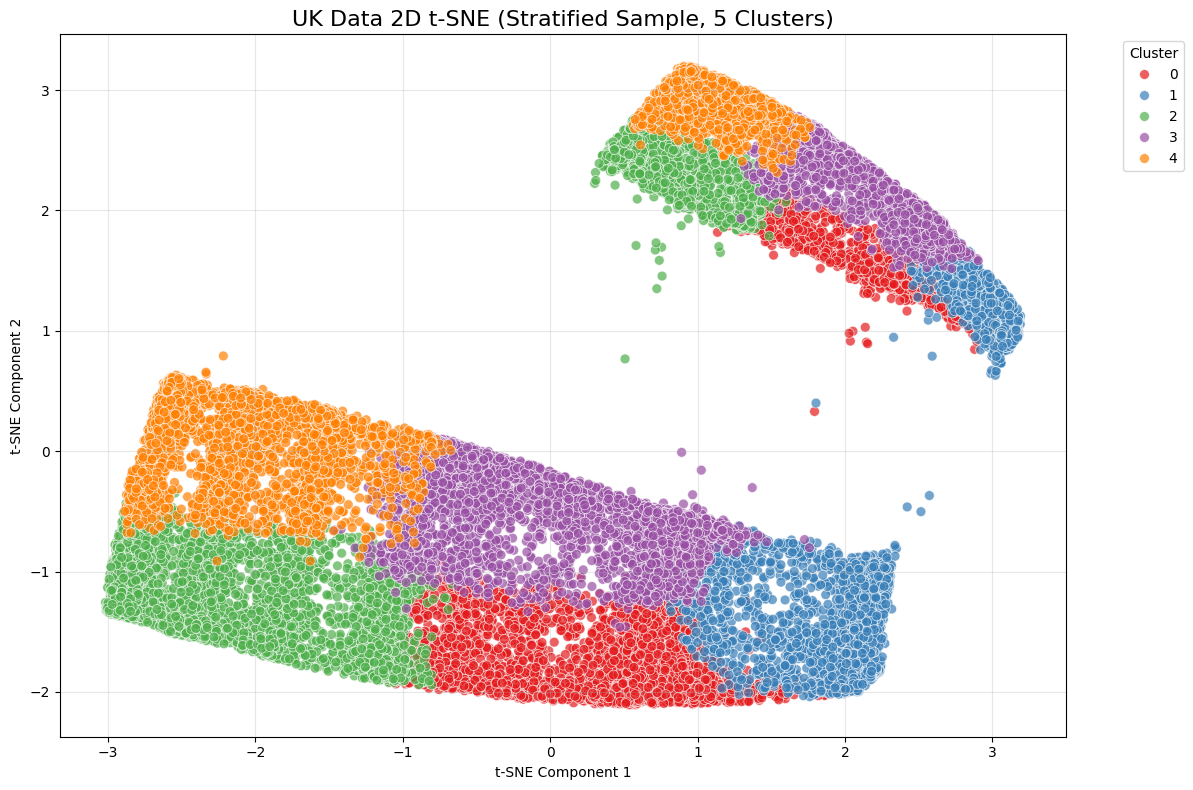

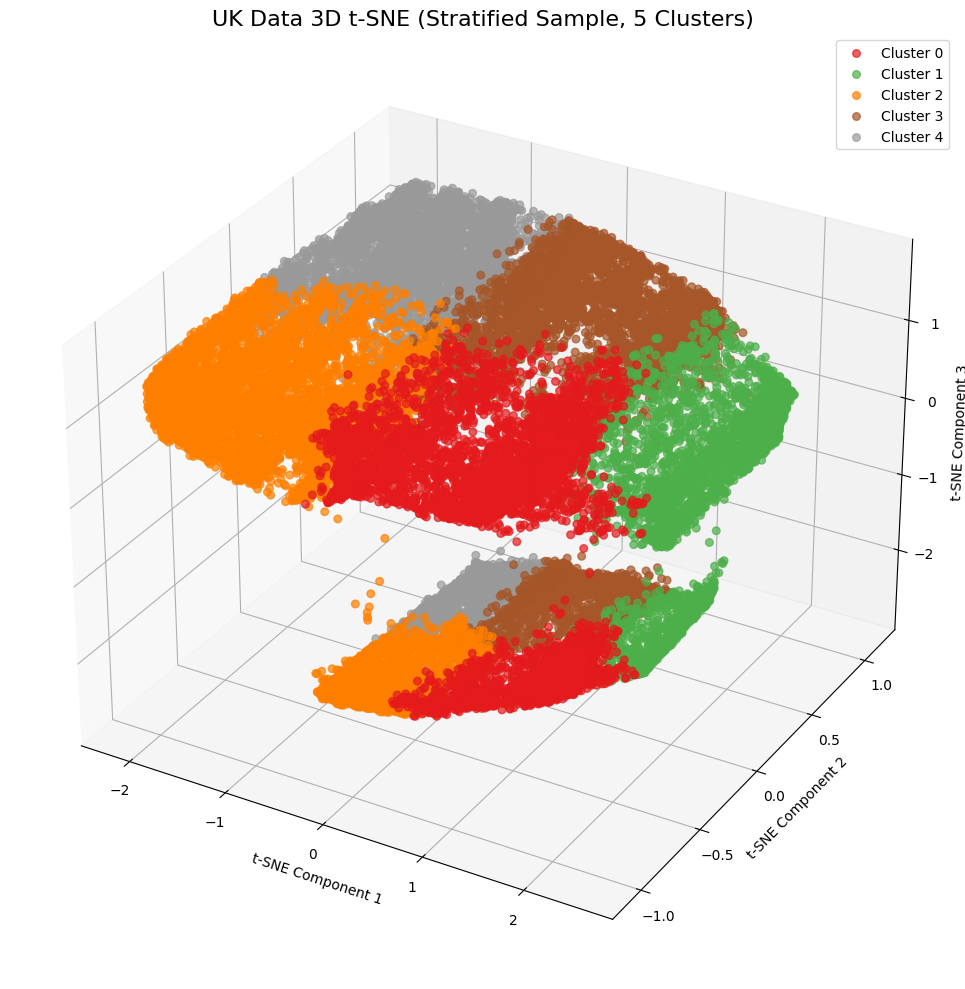

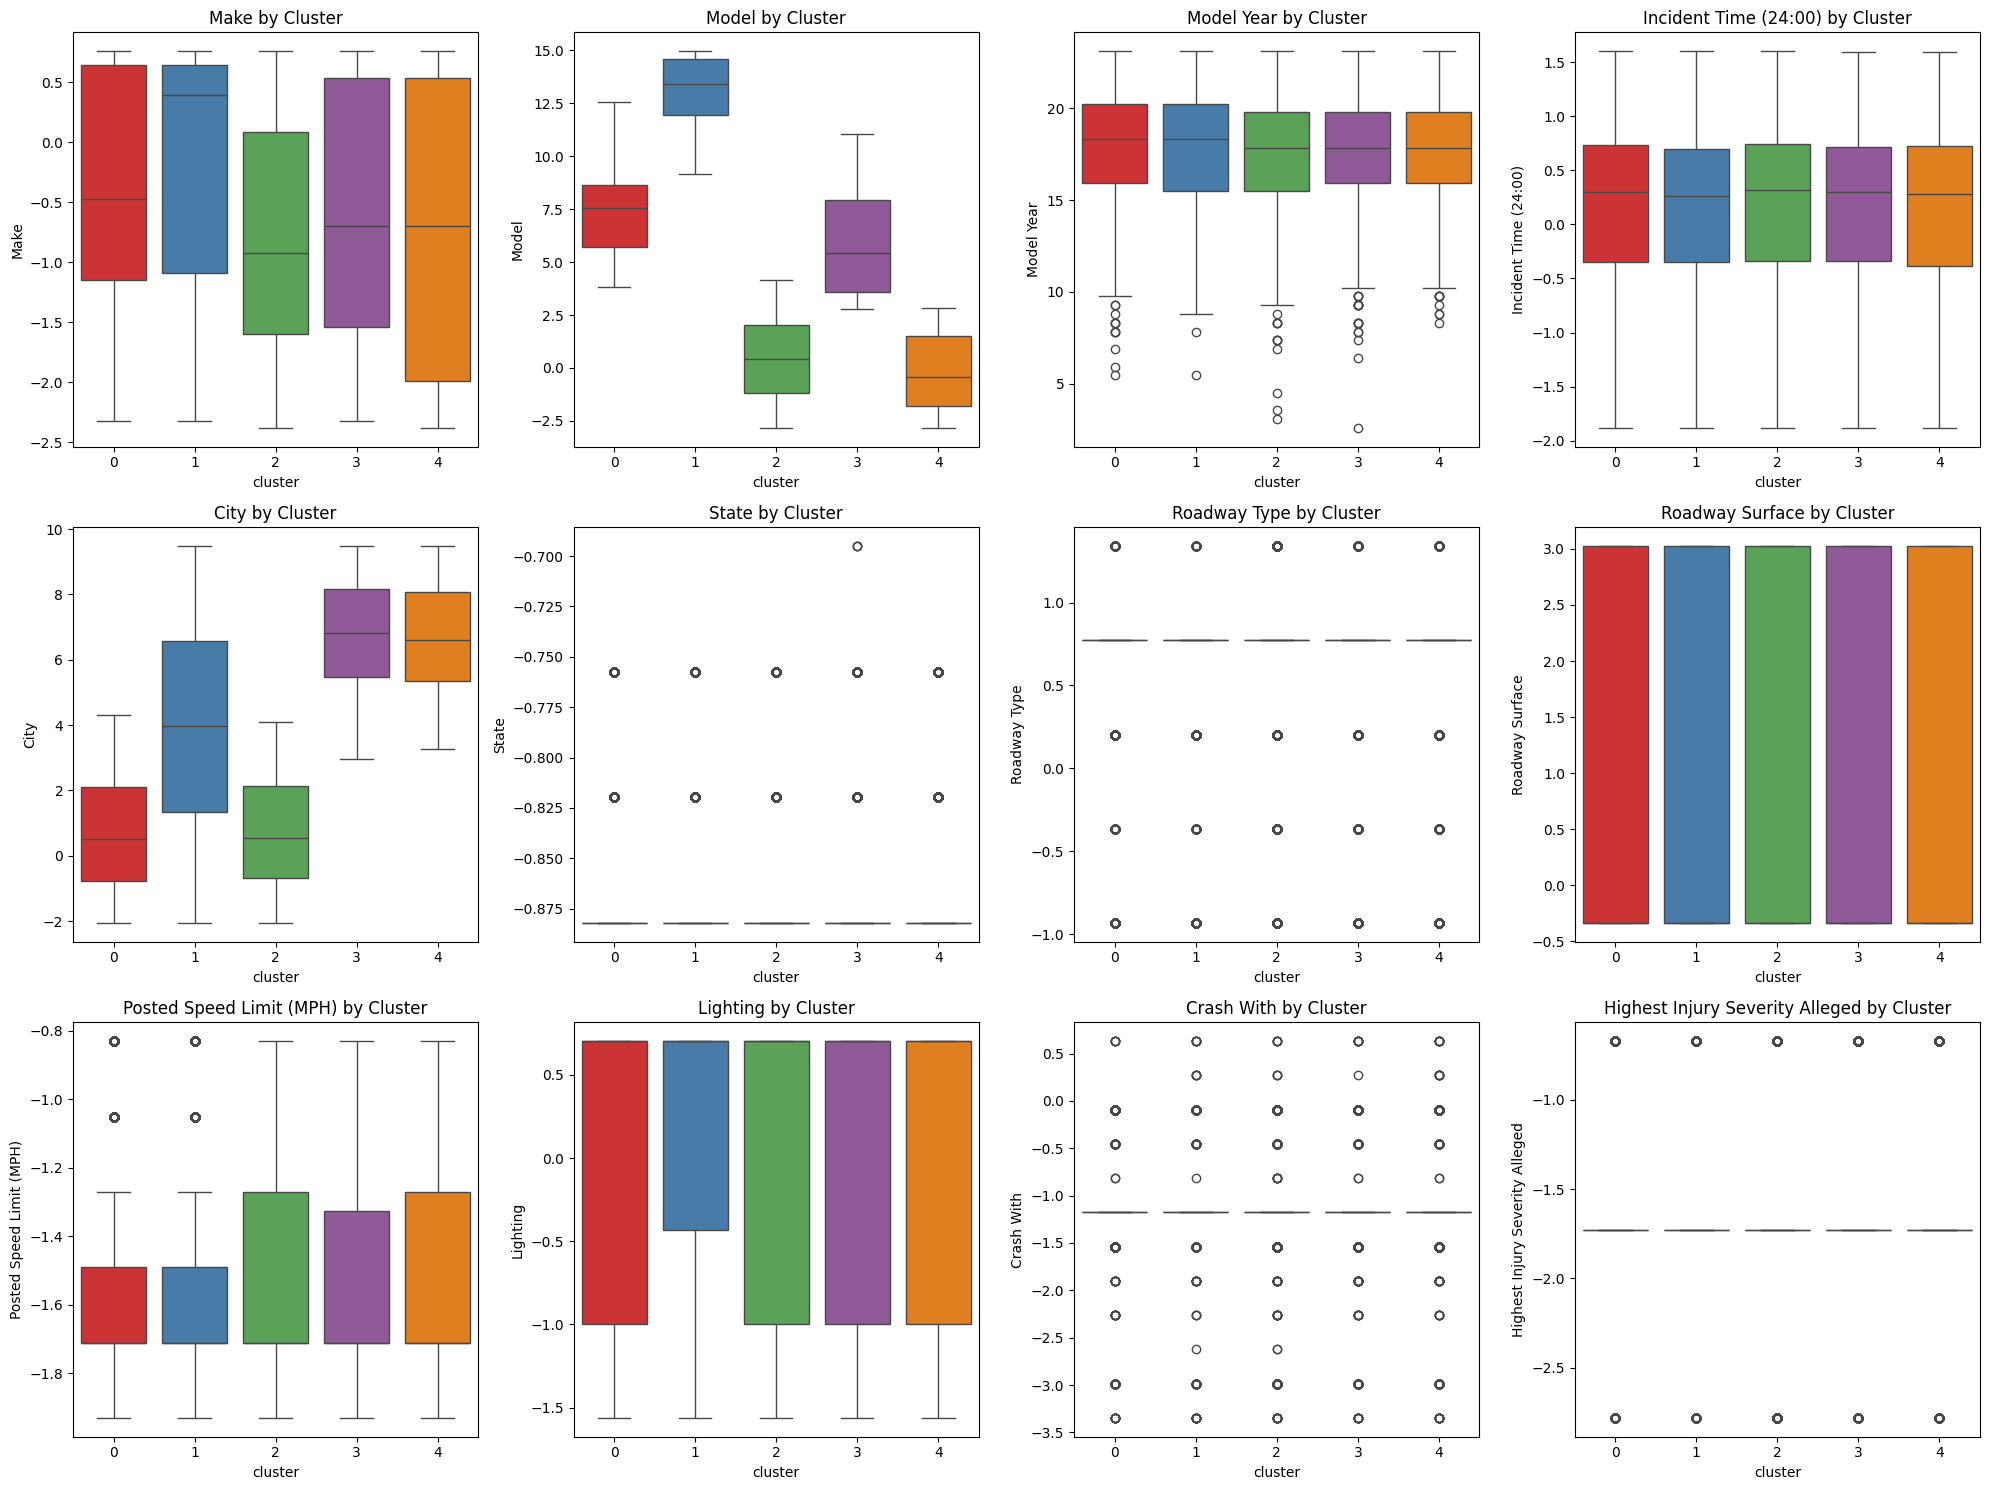

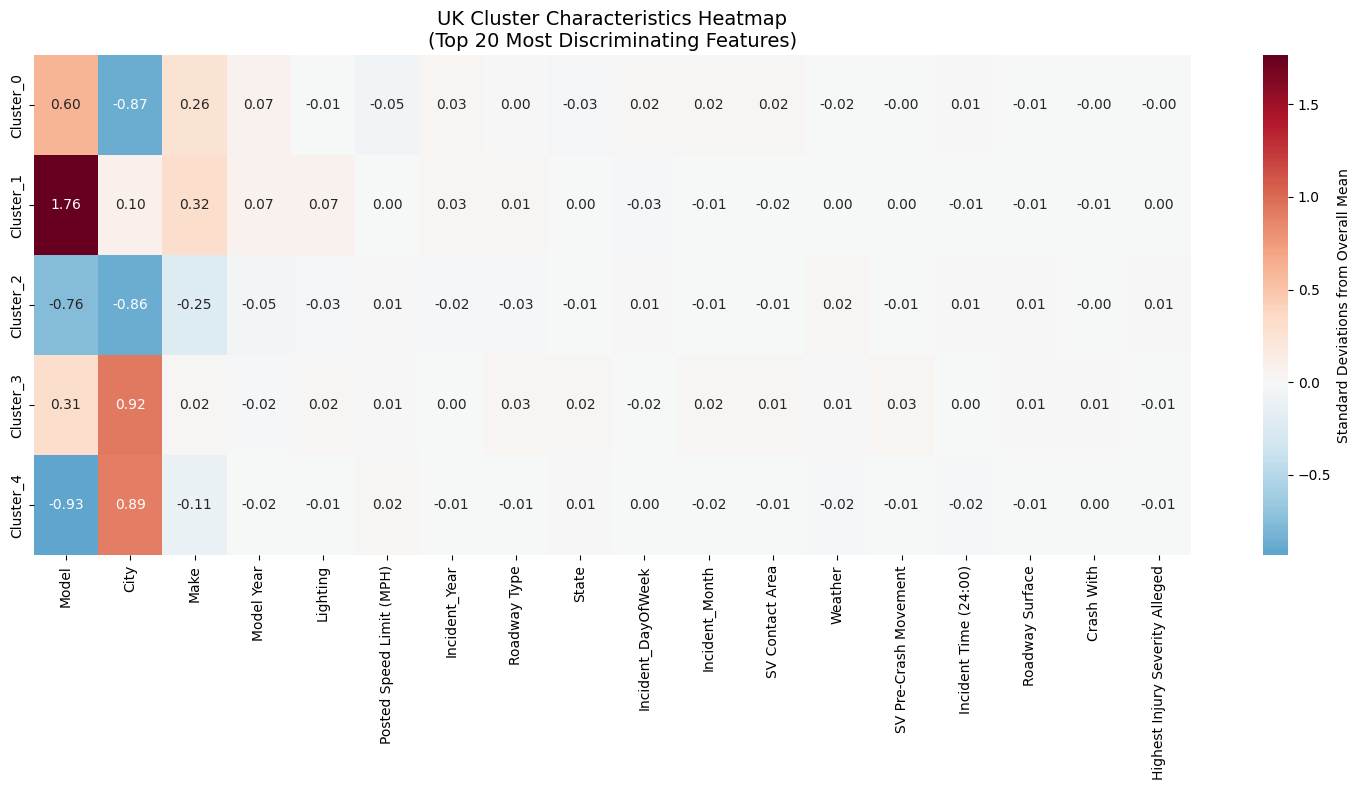


SUMMARY INSIGHTS

1. CLUSTER SIZES:
   Cluster 0: 5,225 samples (17.4%)
   Cluster 1: 4,062 samples (13.5%)
   Cluster 2: 8,257 samples (27.5%)
   Cluster 3: 6,158 samples (20.5%)
   Cluster 4: 6,297 samples (21.0%)

2. TOP 5 MOST IMPORTANT FEATURES FOR CLUSTERING:
   Model: 0.5407
   City: 0.3769
   Make: 0.0556
   Model Year: 0.0053
   Incident Time (24:00): 0.0049

3. PCA EXPLANATION:
   First 3 components explain 80.2% of variance
   PC1: 46.2%, PC2: 21.2%, PC3: 12.8%

4. MODEL PERFORMANCE:
   Random Forest can predict clusters with 98.9% accuracy

Analysis complete! Check the visualizations above for cluster insights.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STEP 1: CLUSTERING AND SAMPLING (Your existing code)
# ============================================================================

# 1. Cluster full UK dataset first
UK_df_scaled['cluster'] = KMeans(n_clusters=5, random_state=42).fit_predict(UK_df_scaled)

# 2. Stratified sample
def stratified_sample(df, stratify_col, n_samples, random_state=42):
    proportions = df[stratify_col].value_counts(normalize=True)
    samples_per_group = (proportions * n_samples).round().astype(int)
    sampled_df = (
        df.groupby(stratify_col, group_keys=False)
          .apply(lambda x: x.sample(min(samples_per_group[x.name], len(x)), random_state=random_state))
          .reset_index(drop=True)
    )
    return sampled_df

UK_sampled_stratified = stratified_sample(UK_df_scaled, stratify_col='cluster', n_samples=30000)

# 3. Run t-SNE on the stratified sample (2D)
print("Running 2D t-SNE on UK data...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=15, max_iter=250, verbose=1)
tsne_results_2d = tsne_2d.fit_transform(UK_sampled_stratified.drop(columns=['cluster']))
UK_sampled_stratified['tsne_1'] = tsne_results_2d[:, 0]
UK_sampled_stratified['tsne_2'] = tsne_results_2d[:, 1]

# 4. Run t-SNE on the stratified sample (3D)
print("Running 3D t-SNE on UK data...")
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=15, max_iter=250, verbose=1)
tsne_results_3d = tsne_3d.fit_transform(UK_sampled_stratified.drop(columns=['cluster', 'tsne_1', 'tsne_2']))
UK_sampled_stratified['tsne_3d_1'] = tsne_results_3d[:, 0]
UK_sampled_stratified['tsne_3d_2'] = tsne_results_3d[:, 1]
UK_sampled_stratified['tsne_3d_3'] = tsne_results_3d[:, 2]

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_tsne_2d(df, title='t-SNE of Data'):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='tsne_1', y='tsne_2', hue='cluster', palette='Set1', alpha=0.7, s=50)
    plt.title(title, fontsize=16)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_tsne_3d(df, title='3D t-SNE of Data'):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get unique clusters and colors
    unique_clusters = sorted(df['cluster'].unique())
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_clusters)))
    
    # Plot each cluster with different colors
    for i, cluster in enumerate(unique_clusters):
        cluster_data = df[df['cluster'] == cluster]
        ax.scatter(cluster_data['tsne_3d_1'], 
                  cluster_data['tsne_3d_2'], 
                  cluster_data['tsne_3d_3'],
                  c=[colors[i]], 
                  label=f'Cluster {cluster}',
                  alpha=0.7,
                  s=30)
    
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    ax.set_title(title, fontsize=16)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# PCA ANALYSIS FOR INTERPRETABILITY
# ============================================================================

def analyze_with_pca_uk(df_scaled, clusters, n_components=5):
    """Use PCA for more interpretable components"""
    
    # Remove cluster column if it exists
    feature_data = df_scaled.drop(columns=['cluster'], errors='ignore')
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(feature_data)
    
    # Create DataFrame with PCA results
    pca_df = pd.DataFrame(pca_results, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['cluster'] = clusters
    
    print("=== UK PCA ANALYSIS ===")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")
    
    # Show feature contributions to each component
    feature_names = feature_data.columns
    components_df = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=feature_names
    )
    
    print("\n=== TOP FEATURE CONTRIBUTIONS TO EACH COMPONENT ===")
    for i in range(min(3, n_components)):  # Show first 3 components
        pc_name = f'PC{i+1}'
        print(f"\n{pc_name} (explains {pca.explained_variance_ratio_[i]:.1%} of variance):")
        
        # Get top positive and negative contributors
        contributions = components_df[pc_name].abs().sort_values(ascending=False)
        top_features = contributions.head(10)
        
        for feature in top_features.index:
            coeff = components_df.loc[feature, pc_name]
            print(f"  {feature}: {coeff:.3f}")
    
    return pca_df, pca, components_df

# ============================================================================
# STATISTICAL CLUSTER PROFILING
# ============================================================================

def statistical_cluster_analysis_uk(df, cluster_col='cluster'):
    """Comprehensive statistical analysis of UK clusters"""
    
    print("\n=== UK STATISTICAL CLUSTER ANALYSIS ===")
    
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Remove cluster and tsne columns from analysis
    cols_to_remove = [cluster_col, 'tsne_1', 'tsne_2', 'tsne_3d_1', 'tsne_3d_2', 'tsne_3d_3']
    for col in cols_to_remove:
        if col in numerical_cols:
            numerical_cols.remove(col)
        if col in categorical_cols:
            categorical_cols.remove(col)
    
    cluster_profiles = {}
    
    for cluster_id in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster_id]
        cluster_profiles[cluster_id] = {}
        
        print(f"\n=== CLUSTER {cluster_id} ({len(cluster_data)} samples, {len(cluster_data)/len(df)*100:.1f}%) ===")
        
        # Numerical features analysis
        if numerical_cols:
            print("\nKey Numerical Features (mean ± std):")
            feature_differences = []
            
            for col in numerical_cols:
                if col in cluster_data.columns:
                    cluster_mean = cluster_data[col].mean()
                    cluster_std = cluster_data[col].std()
                    overall_mean = df[col].mean()
                    overall_std = df[col].std()
                    
                    # Calculate how different this cluster is from overall mean
                    if overall_std > 0:
                        diff_from_overall = (cluster_mean - overall_mean) / overall_std
                        feature_differences.append((col, abs(diff_from_overall), diff_from_overall))
                        
                        cluster_profiles[cluster_id][col] = {
                            'mean': cluster_mean,
                            'std': cluster_std,
                            'diff_from_overall': diff_from_overall
                        }
            
            # Show top 10 most different features
            feature_differences.sort(key=lambda x: x[1], reverse=True)
            for col, abs_diff, diff in feature_differences[:10]:
                cluster_mean = cluster_profiles[cluster_id][col]['mean']
                cluster_std = cluster_profiles[cluster_id][col]['std']
                status = "HIGH" if diff > 0.5 else "LOW" if diff < -0.5 else "NORMAL"
                print(f"  {col}: {cluster_mean:.3f} ± {cluster_std:.3f} ({status}, {diff:+.2f}σ)")
        
        # Categorical features analysis
        if categorical_cols:
            print("\nTop Categorical Features:")
            for col in categorical_cols[:5]:  # Show top 5
                if col in cluster_data.columns and not cluster_data[col].isna().all():
                    top_values = cluster_data[col].value_counts().head(3)
                    cluster_profiles[cluster_id][col] = top_values.to_dict()
                    
                    print(f"  {col}:")
                    for value, count in top_values.items():
                        percentage = (count / len(cluster_data)) * 100
                        print(f"    {value}: {percentage:.1f}%")
    
    return cluster_profiles

# ============================================================================
# FEATURE IMPORTANCE FOR CLUSTER PREDICTION
# ============================================================================

def cluster_feature_importance_uk(df, cluster_col='cluster'):
    """Use Random Forest to find which features best predict UK clusters"""
    
    print("\n=== UK FEATURE IMPORTANCE FOR CLUSTER PREDICTION ===")
    
    # Prepare data
    cols_to_exclude = [cluster_col, 'tsne_1', 'tsne_2', 'tsne_3d_1', 'tsne_3d_2', 'tsne_3d_3']
    feature_data = df.drop(columns=cols_to_exclude, errors='ignore')
    
    # Handle categorical variables (simple encoding)
    feature_data_encoded = pd.get_dummies(feature_data, drop_first=True)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    rf.fit(feature_data_encoded, df[cluster_col])
    
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': feature_data_encoded.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nModel Accuracy: {rf.score(feature_data_encoded, df[cluster_col]):.3f}")
    print("\nTop 20 Most Important Features for UK Cluster Prediction:")
    for idx, row in importance_df.head(20).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    return importance_df, rf

# ============================================================================
# VISUALIZATION HELPERS
# ============================================================================

def plot_cluster_comparison_uk(df, cluster_col='cluster', max_features=12):
    """Create comparison plots for UK clusters"""
    
    # Get numerical features (excluding t-SNE and cluster columns)
    cols_to_exclude = [cluster_col, 'tsne_1', 'tsne_2', 'tsne_3d_1', 'tsne_3d_2', 'tsne_3d_3']
    numerical_features = df.select_dtypes(include=[np.number]).columns
    numerical_features = [col for col in numerical_features if col not in cols_to_exclude][:max_features]
    
    n_features = len(numerical_features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, feature in enumerate(numerical_features):
        if i < len(axes):
            sns.boxplot(data=df, x=cluster_col, y=feature, ax=axes[i], palette='Set1')
            axes[i].set_title(f'{feature} by Cluster')
            axes[i].tick_params(axis='x', rotation=0)
    
    # Hide unused subplots
    for i in range(len(numerical_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_cluster_heatmap_uk(cluster_profiles):
    """Create a heatmap showing UK cluster characteristics"""
    
    # Extract numerical features for heatmap
    numerical_data = {}
    features = []
    
    for cluster_id, profile in cluster_profiles.items():
        numerical_data[f'Cluster_{cluster_id}'] = {}
        for feature, stats in profile.items():
            if isinstance(stats, dict) and 'diff_from_overall' in stats:
                numerical_data[f'Cluster_{cluster_id}'][feature] = stats['diff_from_overall']
                if feature not in features:
                    features.append(feature)
    
    if numerical_data and features:
        heatmap_df = pd.DataFrame(numerical_data).T
        
        # Select top features by variance across clusters
        feature_variance = heatmap_df.var().sort_values(ascending=False)
        top_features = feature_variance.head(20).index.tolist()
        heatmap_df = heatmap_df[top_features]
        
        plt.figure(figsize=(15, 8))
        sns.heatmap(heatmap_df, annot=True, cmap='RdBu_r', center=0, 
                   fmt='.2f', cbar_kws={'label': 'Standard Deviations from Overall Mean'})
        plt.title('UK Cluster Characteristics Heatmap\n(Top 20 Most Discriminating Features)', fontsize=14)
        plt.tight_layout()
        plt.show()

# ============================================================================
# COMPREHENSIVE ANALYSIS FUNCTION
# ============================================================================

def comprehensive_uk_cluster_analysis(df_scaled, df_sampled, categorical_cols):
    """Run all analysis methods for UK data"""
    
    print("UK COMPREHENSIVE CLUSTER ANALYSIS (5 Clusters)")
    print("=" * 60)
    
    # Display cluster distribution
    print("\nCluster Distribution:")
    cluster_counts = df_sampled['cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(df_sampled)) * 100
        print(f"Cluster {cluster_id}: {count:,} samples ({percentage:.1f}%)")
    
    # Method 1: PCA Analysis
    pca_df, pca_model, components_df = analyze_with_pca_uk(df_scaled, df_scaled['cluster'])
    
    # Method 2: Statistical Analysis
    cluster_profiles = statistical_cluster_analysis_uk(df_sampled)
    
    # Method 3: Feature Importance
    importance_df, rf_model = cluster_feature_importance_uk(df_sampled)
    
    # Method 4: Visualizations
    print("\nCreating visualizations...")
    
    # 2D t-SNE plot
    plot_tsne_2d(df_sampled, title='UK Data 2D t-SNE (Stratified Sample, 5 Clusters)')
    
    # 3D t-SNE plot
    plot_tsne_3d(df_sampled, title='UK Data 3D t-SNE (Stratified Sample, 5 Clusters)')
    
    # Feature comparison plots
    plot_cluster_comparison_uk(df_sampled)
    
    # Cluster characteristics heatmap
    create_cluster_heatmap_uk(cluster_profiles)
    
    return {
        'pca_results': pca_df,
        'pca_model': pca_model,
        'components': components_df,
        'cluster_profiles': cluster_profiles,
        'feature_importance': importance_df,
        'rf_model': rf_model,
        'cluster_distribution': cluster_counts
    }

# ============================================================================
# EXECUTE ANALYSIS
# ============================================================================

# Define UK categorical columns (adjust as needed for your UK dataset)
uk_categorical_cols = ['Make', 'Model', 'Model Year', 'ADS Equipped?', 
                      'Automation System Engaged?', 'Incident Time (24:00)', 'City', 'State',
                      'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting',
                      'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement',
                      'Weather', 'SV Contact Area', 'Country']

# Run comprehensive analysis
print("Starting comprehensive UK cluster analysis...")
uk_results = comprehensive_uk_cluster_analysis(UK_df_scaled, UK_sampled_stratified, uk_categorical_cols)

# ============================================================================
# SUMMARY INSIGHTS
# ============================================================================

print("\n" + "="*60)
print("SUMMARY INSIGHTS")
print("="*60)

print(f"\n1. CLUSTER SIZES:")
for cluster_id, count in uk_results['cluster_distribution'].items():
    percentage = (count / len(UK_sampled_stratified)) * 100
    print(f"   Cluster {cluster_id}: {count:,} samples ({percentage:.1f}%)")

print(f"\n2. TOP 5 MOST IMPORTANT FEATURES FOR CLUSTERING:")
for idx, row in uk_results['feature_importance'].head(5).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

print(f"\n3. PCA EXPLANATION:")
pca_var = uk_results['pca_model'].explained_variance_ratio_
print(f"   First 3 components explain {np.sum(pca_var[:3]):.1%} of variance")
print(f"   PC1: {pca_var[0]:.1%}, PC2: {pca_var[1]:.1%}, PC3: {pca_var[2]:.1%}")

print(f"\n4. MODEL PERFORMANCE:")
print(f"   Random Forest can predict clusters with {uk_results['rf_model'].score(pd.get_dummies(UK_sampled_stratified.drop(columns=['cluster', 'tsne_1', 'tsne_2', 'tsne_3d_1', 'tsne_3d_2', 'tsne_3d_3']), drop_first=True), UK_sampled_stratified['cluster']):.1%} accuracy")

print("\nAnalysis complete! Check the visualizations above for cluster insights.")